In [1]:
import numpy as np
from flask import Flask, request, jsonify, render_template
import pickle
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#!pwd
#!pip install flask

In [2]:
gen_model = tf.keras.models.load_model('generalized_model.h5', compile=False) 
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [3]:
#test model on input data
#path = '/Users/chitramac/Desktop/archive/'
path = 'us_etf_stocks_dataset\\'
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def predict_data(model, names, timestep = 50, date = None):
    for name in names:
        scaler = MinMaxScaler()

        data = pd.read_csv(path + f'Stocks\\{name}.us.txt')
        #data = pd.read_csv(path + f'Stocks/{name.lower()}.us.txt')
        if date:
            start_date = data['Date'] >= date
            data = data[start_date]


        data = data['Open']
        data = np.array(data)
        data = data.reshape(-1, 1)
        scaled_data = scaler.fit_transform(data)

        X_test = []
        for i in range(timestep, len(scaled_data)):
            X_test.append(scaled_data[i - timestep:i, 0])
        
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        prediction = model.predict(X_test)
        prediction = scaler.inverse_transform(prediction)

        MSE = mean_squared_error(data[timestep:], prediction)
        R2 = r2_score(data[timestep:], prediction)

        name = name.upper()
        
        plt.plot(data[timestep:], color = 'black', label = f'Actual {name} Stock Price')
        plt.plot(prediction, color = 'green', label = f'Predicted {name} Stock Price')
        plt.title(f'{name} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.savefig('./static/recent_img.png')
        # plt.show()
        plt.clf()
        return(MSE, R2)


160/160 [==============================] - 3s 20ms/step
MSE: 256.964804121623
R2: 0.9955422338291552


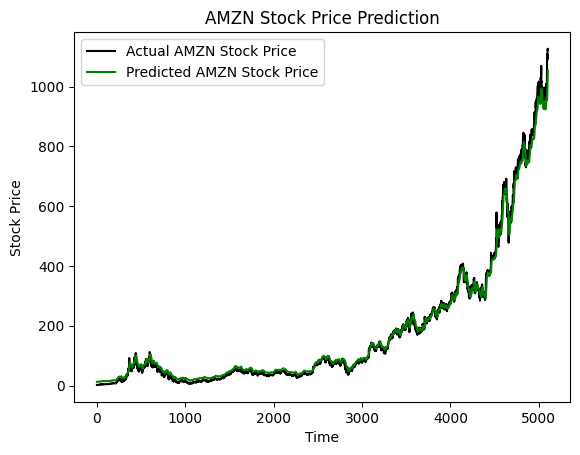

In [15]:
a = predict_data(gen_model, ["AMZN", "NVDA"], timestep = 50, date = None)

### Frontend

In [5]:
app = Flask(__name__)

@app.route('/', methods=['GET'])
def home():
    return render_template("index.html")

@app.route('/', methods=['POST'])
def predict():
    values = list(request.form.values())
    stockfilename = ''.join(values)

    try:
        # check if ticker is in our dataset
        pd.read_csv(path + f'Stocks\\{stockfilename}.us.txt')

        ans = predict_data(gen_model, [stockfilename], timestep=50, date=None)
        return render_template("output.html", data=ans)
    
    except Exception as e:
        # Handle any other exceptions that may occur
        error_msg = "The stock ticker entered is not found. Please try another ticker." 
        print(e)
        return render_template("index.html", error=error_msg)


if __name__ == "__main__":
    app.run(port=2000, debug = False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:2000
Press CTRL+C to quit
127.0.0.1 - - [02/Jun/2023 13:05:20] "GET / HTTP/1.1" 200 -


357/357 [==============================] - 8s 22ms/step


127.0.0.1 - - [02/Jun/2023 13:05:36] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:05:36] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:05:39] "GET / HTTP/1.1" 200 -


99/99 [==============================] - 3s 31ms/step


127.0.0.1 - - [02/Jun/2023 13:05:51] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:05:51] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:06:39] "GET / HTTP/1.1" 200 -


147/147 [==============================] - 5s 31ms/step


127.0.0.1 - - [02/Jun/2023 13:10:14] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:10:14] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:10:19] "GET / HTTP/1.1" 200 -


246/246 [==============================] - 7s 27ms/step


127.0.0.1 - - [02/Jun/2023 13:10:30] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:10:30] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:10:33] "GET / HTTP/1.1" 200 -


24/24 [==============================] - 1s 28ms/step


127.0.0.1 - - [02/Jun/2023 13:10:46] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:10:46] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:10:51] "GET / HTTP/1.1" 200 -


103/103 [==============================] - 3s 32ms/step


127.0.0.1 - - [02/Jun/2023 13:13:21] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:13:21] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:13:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:13:32] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\gap.us.txt'


127.0.0.1 - - [02/Jun/2023 13:13:34] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\uber.us.txt'


127.0.0.1 - - [02/Jun/2023 13:13:36] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\shop .us.txt'
18/18 [==============================] - 1s 36ms/step


127.0.0.1 - - [02/Jun/2023 13:13:39] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:13:39] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:14:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:14:20] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\584 .us.txt'


127.0.0.1 - - [02/Jun/2023 13:14:22] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\cjokndoie.us.txt'


127.0.0.1 - - [02/Jun/2023 13:14:23] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\34ropewfoijerf.us.txt'
 5/99 [>.............................] - ETA: 2s

127.0.0.1 - - [02/Jun/2023 13:14:25] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\erfd.us.txt'
99/99 [==============================] - 3s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:14:28] "POST / HTTP/1.1" 200 -


22/22 [==============================] - 1s 29ms/step


127.0.0.1 - - [02/Jun/2023 13:14:31] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:14:31] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:15:10] "GET / HTTP/1.1" 200 -


357/357 [==============================] - 11s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:24:45] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:24:45] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:26:15] "GET / HTTP/1.1" 200 -


357/357 [==============================] - 10s 29ms/step


127.0.0.1 - - [02/Jun/2023 13:28:47] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:28:47] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:29:01] "GET / HTTP/1.1" 200 -


19/19 [==============================] - 1s 35ms/step


127.0.0.1 - - [02/Jun/2023 13:29:07] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:29:07] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:31:32] "GET / HTTP/1.1" 200 -


24/24 [==============================] - 1s 31ms/step


127.0.0.1 - - [02/Jun/2023 13:34:33] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:34:33] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:35:15] "GET / HTTP/1.1" 200 -


191/246 [======================>.......] - ETA: 1s

127.0.0.1 - - [02/Jun/2023 13:35:29] "POST / HTTP/1.1" 200 -


246/246 [==============================] - 7s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:35:31] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:35:31] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:37:43] "GET / HTTP/1.1" 200 -


57/57 [==============================] - 2s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:37:50] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:37:50] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:37:53] "GET / HTTP/1.1" 200 -


160/160 [==============================] - 5s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:38:01] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:38:02] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:39:37] "GET / HTTP/1.1" 200 -


46/99 [============>.................] - ETA: 1s

127.0.0.1 - - [02/Jun/2023 13:39:48] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\rwt\\.us.txt'
99/99 [==============================] - 3s 32ms/step


127.0.0.1 - - [02/Jun/2023 13:39:50] "POST / HTTP/1.1" 200 -


99/99 [==============================] - 3s 31ms/step


127.0.0.1 - - [02/Jun/2023 13:39:56] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:39:56] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:40:01] "GET / HTTP/1.1" 200 -


228/248 [==========================>...] - ETA: 0s

127.0.0.1 - - [02/Jun/2023 13:40:34] "POST / HTTP/1.1" 200 -


248/248 [==============================] - 7s 26ms/step


127.0.0.1 - - [02/Jun/2023 13:40:35] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:40:35] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:41:18] "GET / HTTP/1.1" 200 -


194/376 [==============>...............] - ETA: 4s

127.0.0.1 - - [02/Jun/2023 13:41:35] "POST / HTTP/1.1" 200 -


376/376 [==============================] - 8s 21ms/step


127.0.0.1 - - [02/Jun/2023 13:41:39] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:41:39] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:42:10] "GET / HTTP/1.1" 200 -


19/19 [==============================] - 1s 31ms/step


127.0.0.1 - - [02/Jun/2023 13:42:14] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:42:14] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:42:34] "GET / HTTP/1.1" 200 -


267/267 [==============================] - 8s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:44:25] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:44:25] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:45:08] "GET / HTTP/1.1" 200 -


103/103 [==============================] - 3s 29ms/step


127.0.0.1 - - [02/Jun/2023 13:45:14] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:45:14] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:46:45] "GET / HTTP/1.1" 200 -


438/438 [==============================] - 14s 33ms/step


127.0.0.1 - - [02/Jun/2023 13:48:23] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:48:23] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:48:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:48:49] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\pfz.us.txt'
99/99 [==============================] - 3s 28ms/step


127.0.0.1 - - [02/Jun/2023 13:49:03] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:49:03] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:50:41] "GET / HTTP/1.1" 200 -


57/57 [==============================] - 2s 29ms/step


127.0.0.1 - - [02/Jun/2023 13:50:46] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:50:46] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:51:21] "GET / HTTP/1.1" 200 -


57/57 [==============================] - 2s 31ms/step


127.0.0.1 - - [02/Jun/2023 13:52:51] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:52:52] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:53:42] "GET / HTTP/1.1" 200 -


99/99 [==============================] - 3s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:53:50] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:53:50] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:53:58] "GET / HTTP/1.1" 200 -


19/19 [==============================] - 1s 30ms/step


127.0.0.1 - - [02/Jun/2023 13:54:02] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:54:02] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:55:01] "GET / HTTP/1.1" 200 -


357/357 [==============================] - 10s 29ms/step


127.0.0.1 - - [02/Jun/2023 13:57:53] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 13:57:53] "GET /static/recent_img.png HTTP/1.1" 200 -


<Figure size 640x480 with 0 Axes>